In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=12,5

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [2]:
stock=yf.download('^NSEBANK',start='2017-08-8',end="2022-08-04")

[*********************100%***********************]  1 of 1 completed


In [3]:
stock.shape

(1227, 6)

In [4]:
stock.to_csv('SBIN.csv')
df=pd.read_csv('SBIN.csv')
df.reset_index
df.tail()


,Date,Open,High,Low,Close,Adj Close,Volume
1222,2022-07-28,37102.449219,37414.398438,37028.500000,37378.148438,37378.148438,172500
1223,2022-07-29,37717.300781,37754.648438,37221.148438,37491.398438,37491.398438,166900
1224,2022-08-01,37594.148438,37939.601562,37407.199219,37903.199219,37903.199219,346400
1225,2022-08-02,37767.699219,38179.851562,37632.300781,38024.000000,38024.000000,317300
1226,2022-08-03,37954.550781,38068.601562,37692.949219,37989.250000,37989.250000,200300


In [5]:
## here, i m changing date format to ---pd.to_datetime, and df index set as date

df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

df

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2017-08-08,2017-08-08,24942.199219,24966.050781,24534.349609,24599.500000,24599.500000,0
2017-08-09,2017-08-09,24519.250000,24532.400391,24328.099609,24374.599609,24374.599609,0
2017-08-10,2017-08-10,24300.449219,24326.900391,23822.199219,24217.349609,24217.349609,0
2017-08-11,2017-08-11,23958.250000,24191.199219,23868.300781,23985.750000,23985.750000,0
2017-08-14,2017-08-14,24051.050781,24212.150391,24038.150391,24115.750000,24115.750000,0
...,...,...,...,...,...,...,...
2022-07-28,2022-07-28,37102.449219,37414.398438,37028.500000,37378.148438,37378.148438,172500
2022-07-29,2022-07-29,37717.300781,37754.648438,37221.148438,37491.398438,37491.398438,166900
2022-08-01,2022-08-01,37594.148438,37939.601562,37407.199219,37903.199219,37903.199219,346400


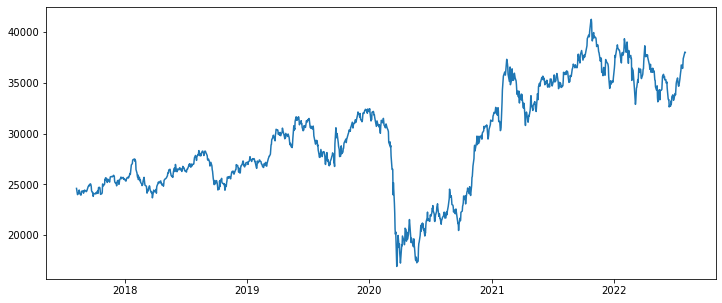

In [6]:
plt.figure(figsize=(12,5))
plt.plot(df["Close"],label='Close Price history')

In [7]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


In [8]:
# here, i am making a new df for model, including the date and close only.
new_dataset=df[['Date','Close']].copy()
new_dataset.drop('Date',axis=1,inplace=True)
new_dataset=new_dataset.sort_index(ascending=True,axis=0)
new_dataset.shape

(1227, 1)

In [9]:
#importing models 
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [10]:
#copying values from newly created dataset
final_dataset=new_dataset.values
final_dataset

array([[24599.5       ],
       [24374.59960938],
       [24217.34960938],
       ...,
       [37903.19921875],
       [38024.        ],
       [37989.25      ]])

In [11]:
#train-test split
train_data=final_dataset[0:987]
valid_data=final_dataset[987:]
valid_data.shape

(240, 1)

In [12]:
#now model can be sensitive so normalise values via scaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

In [13]:
x_train_data,y_train_data=[],[]
## here for loop will be executed for 60 to 986 times
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i])  ##here o to 60 will be added
    y_train_data.append(scaled_data[i])       ##here, 61st price will be added

In [14]:
len(y_train_data)

927

In [15]:
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data.shape

(927, 60, 1)

In [16]:
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
x_train_data.shape

(927, 60, 1)

In [17]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [18]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 19s - loss: 0.0032 - 19s/epoch - 20ms/step


In [19]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)
len(inputs_data)
inputs_data.shape

(300, 1)

In [20]:
inputs_data.shape

(300, 1)

In [21]:
X_test=[]
for i in range(60,len(inputs_data)):
    X_test.append(inputs_data[i-60:i])
X_test=np.array(X_test)
X_test.shape

(240, 60, 1)

In [22]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

8/8 [==============================] - 1s 15ms/step


In [23]:
len(closing_price)

240

C:\Users\tanma\AppData\Local\Temp\ipykernel_19756\4128311284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


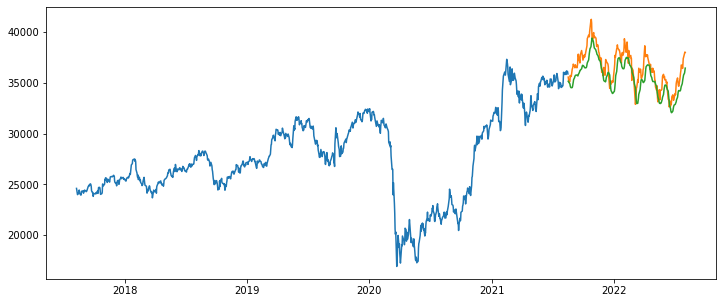

In [24]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

In [25]:
#closing_price

In [26]:
Z_test=inputs_data[-60:]
#Z_test=np.array(Z_test)
#Z_test=np.reshape(Z_test,(Z_test.shape[0],Z_test.shape[1],1))
#a=Z_test.transpose()
Z_test=Z_test.T
Z_test=np.array(Z_test)
Z_test=np.reshape(Z_test,(Z_test.shape[0],Z_test.shape[1],1))
Z_test

array([[[0.68314366],
        [0.66625279],
        [0.68583491],
        [0.71479372],
        [0.70911133],
        [0.67424176],
        [0.71374522],
        [0.71256117],
        [0.71431059],
        [0.71633979],
        [0.74739975],
        [0.76871507],
        [0.77749972],
        [0.7635383 ],
        [0.76902345],
        [0.76872936],
        [0.75480713],
        [0.75625234],
        [0.74333331],
        [0.74128355],
        [0.74701122],
        [0.72227305],
        [0.67795067],
        [0.67406508],
        [0.67520191],
        [0.6455193 ],
        [0.65069807],
        [0.64830299],
        [0.66914738],
        [0.65490232],
        [0.66681398],
        [0.68706217],
        [0.69461957],
        [0.68767893],
        [0.67236064],
        [0.67874218],
        [0.68344385],
        [0.69995036],
        [0.6948107 ],
        [0.71571275],
        [0.74022076],
        [0.74859842],
        [0.76280847],
        [0.74893555],
        [0.73641741],
        [0

In [27]:
Z_test=inputs_data[-60:]
#Z_test=np.array(Z_test)
#Z_test=np.reshape(Z_test,(Z_test.shape[0],Z_test.shape[1],1))
#a=Z_test.transpose()
Z_test=Z_test.T
Z_test=np.array(Z_test)
Z_test=np.reshape(Z_test,(Z_test.shape[0],Z_test.shape[1],1))
Z_test


closing_price01=lstm_model.predict(Z_test)
closing_price01
closing_price01=scaler.inverse_transform(closing_price01)
closing_price01

1/1 [==============================] - 0s 24ms/step


array([[36634.312]], dtype=float32)